### CS584 Assignment 4 David Fu


In [19]:
import os
import pandas as pd
import re
import math
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Dropout, Embedding, Input, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.backend as backend
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt

##### Text Processing functions

In [2]:
"""
READS Text File and return all of body as a string
"""
def read_input(input_path:str) -> str:
    file_data = open(input_path , 'r')
    
    return file_data.read()


file1 = read_input('./a4-data/q1/28054-0.txt')
file2 = read_input('./a4-data/q1/pg1661.txt')
file3 = read_input('./a4-data/q1/pg31100.txt')

In [3]:
"""
Text pre-processing function
"""
def preprocess(doc, label, sample_size):

    paragraphs = doc.split('\n\n')
    data_set = [paragraph.strip() for paragraph in paragraphs if len(paragraph) > sample_size]
    data = [re.sub('[\W_]+', ' ', sample.lower().strip()) for sample in data_set]
    size = len(data)

    label_array = np.ones((size,)) * label
    df = pd.DataFrame({'paragraph': data, 'category':label_array })
    print('The total number of examples for category ' + str(label)+ ' is: ' + str(size))
    return df, size

df1, num1 = preprocess(file1, 0, 400)
df2, num2 = preprocess(file2, 1, 95)
df3, num3 = preprocess(file3, 2, 810)

The total number of examples for category 0 is: 1367
The total number of examples for category 1 is: 1397
The total number of examples for category 2 is: 1381


In [4]:
df = pd.concat([df1,df2,df3])
X = df['paragraph']
y = df['category']
df

,paragraph,category
0,this ebook is for the use of anyone anywhere i...,0.0
1,part i book i the history of a family chapter ...,0.0
2,alexey fyodorovitch karamazov was the third so...,0.0
3,he was married twice and had three sons the el...,0.0
4,immediately after the elopement adelaïda ivano...,0.0
...,...,...
1376,elinor s marriage divided her as little from h...,2.0
1377,willoughby could not hear of her marriage with...,2.0
1378,creating the works from public domain print ed...,2.0
1379,1 c the project gutenberg literary archive fou...,2.0


In [5]:
paragraphs = X.values
categorys = y

sentences_train, sentences_test, y_train, y_test = train_test_split(paragraphs, categorys, test_size=0.20, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(sentences_train, y_train, test_size=0.05, random_state=5)

tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1                          

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

label_train = to_categorical(y_train)
label_validation = to_categorical(y_val)
label_test = to_categorical(y_test)

In [6]:
print('Shape of x_train: ' + str(X_train.shape))
print('Shape of label_train: ' + str(label_train.shape))
print('Shape of x_validation: ' + str(X_validation.shape))
print('Shape of y_validation: ' + str(label_validation.shape))
print('Shape of x_test: ' + str(X_test.shape))
print('Shape of y_test: ' + str(label_test.shape))

Shape of x_train: (3150, 100)
Shape of label_train: (3150, 3)
Shape of x_validation: (166, 100)
Shape of y_validation: (166, 3)
Shape of x_test: (829, 100)
Shape of y_test: (829, 3)


In [7]:
inputs = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, 100)(inputs)

# layer 1
conv1 = Conv1D(filters=12, kernel_size=4, activation='relu')(embedding)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling1D(pool_size=3)(drop1)
flat1 = Flatten()(pool1)

# layer 2
conv2 = Conv1D(filters=12, kernel_size=2, activation='sigmoid')(embedding)
drop2 = Dropout(0.3)(conv2)
pool2 = MaxPooling1D(pool_size=3)(drop2)
flat2 = Flatten()(pool2)

# layer 3
conv3 = Conv1D(filters=12, kernel_size=5, activation='softmax')(embedding)
drop3 = Dropout(0.4)(conv3)
pool3 = MaxPooling1D(pool_size=3)(drop3)
flat3 = Flatten()(pool3)

# layer 4
conv4 = Conv1D(filters=12, kernel_size=3, activation='relu')(embedding)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling1D(pool_size=3)(drop4)
flat4 = Flatten()(pool4)

# merge
network = concatenate([flat1, flat2, flat3, flat4])

# interpretation
dense1 = Dense(10, activation='relu')(network)
outputs = Dense(3, activation='softmax')(dense1)
cnn_model = Model(inputs=[inputs], outputs=outputs)
# compile
opt = optimizers.Adam(learning_rate=0.001)
cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# summarize
print(cnn_model.summary())



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     1675500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 97, 12)       4812        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 99, 12)       2412        embedding_1[0][0]                
___________________________________________________________________________________________

In [8]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 100)(inputs))
lstm_model.add(LSTM(30))
lstm_model.add(Dense(3, activation='relu'))
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 10)           30        
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                4920      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 93        
Total params: 5,043
Trainable params: 5,043
Non-trainable params: 0
_________________________________________________________________
None


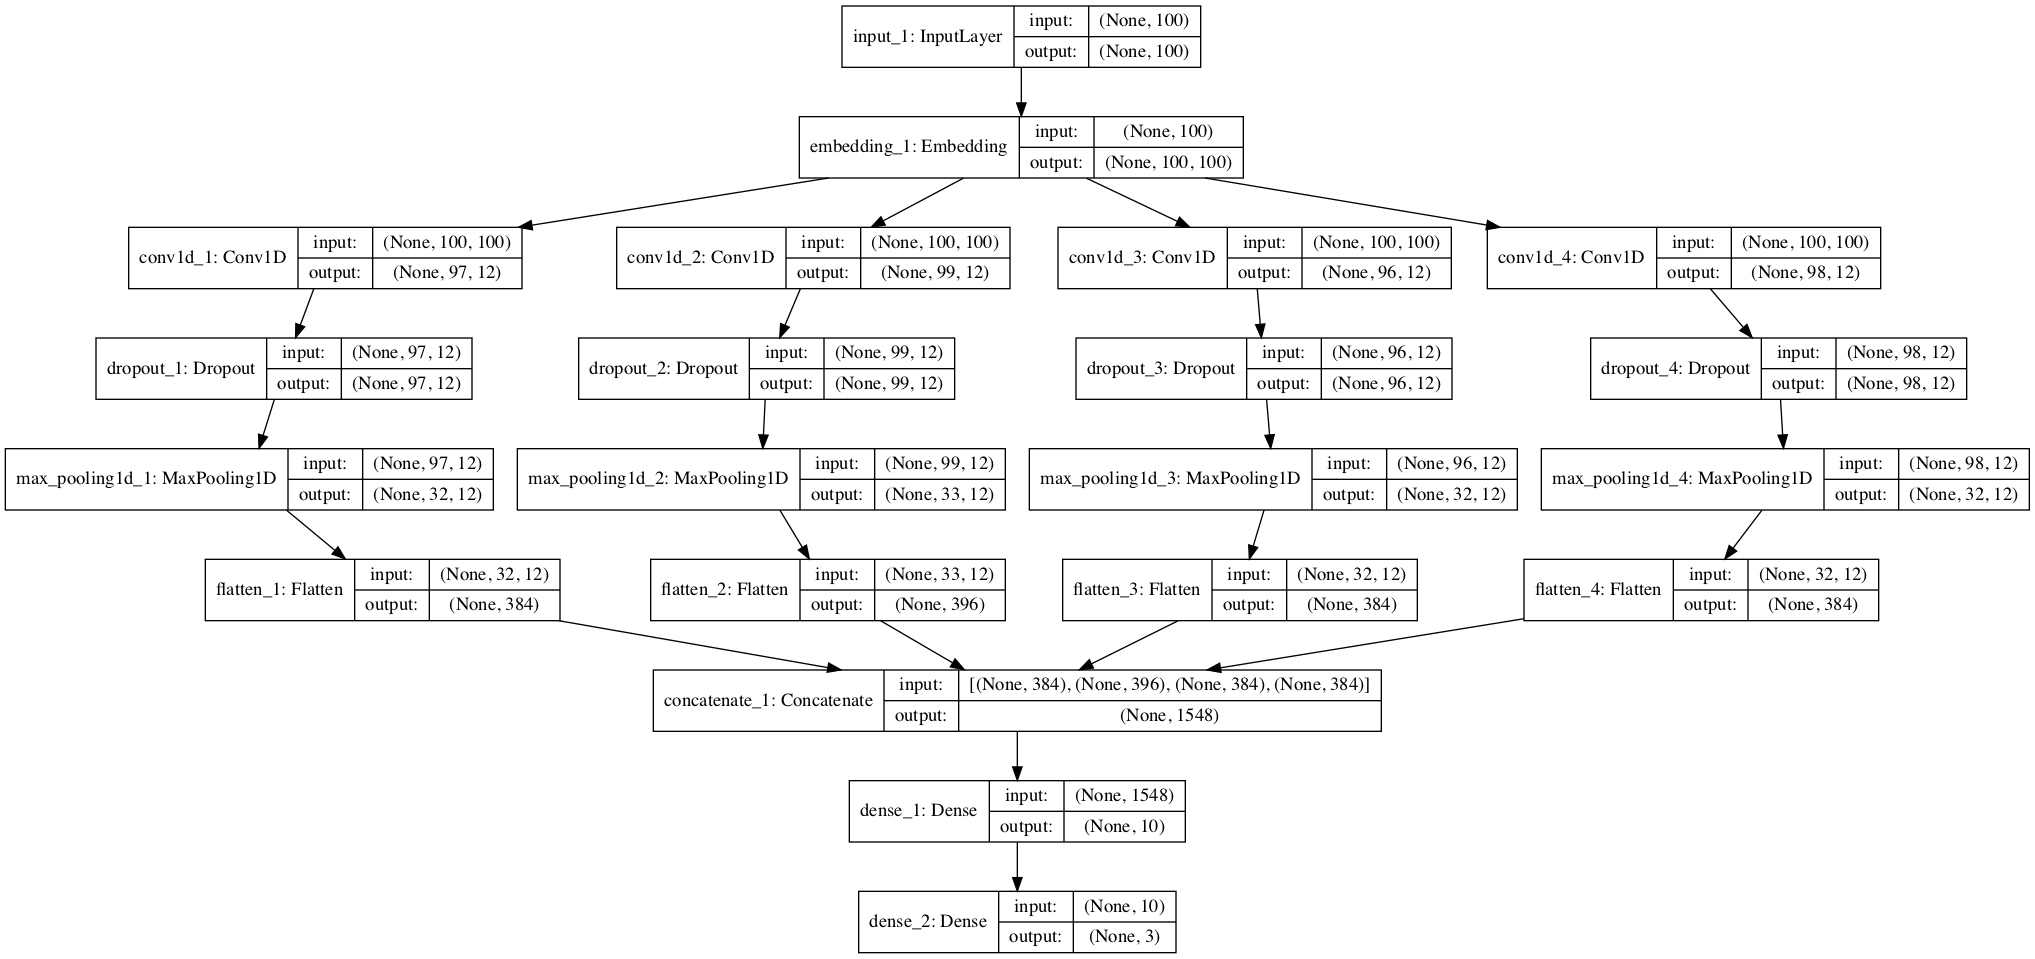

In [16]:
plot_model(cnn_model, show_shapes=True, to_file='classification_model.png')

In [10]:
def perplexity(predict, label):
    return backend.exp(backend.categorical_crossentropy(predict, label))

In [11]:
result1 = cnn_model.fit([X_train], label_train, epochs=100, validation_data=([X_validation], label_validation), batch_size=32)


Train on 3150 samples, validate on 166 samples
Epoch 1/100
3150/3150 [==============================] - 4s 1ms/step - loss: 0.9123 - accuracy: 0.5171 - val_loss: 0.8515 - val_accuracy: 0.4940
Epoch 2/100
3150/3150 [==============================] - 3s 951us/step - loss: 0.6305 - accuracy: 0.7432 - val_loss: 0.5959 - val_accuracy: 0.8313
Epoch 3/100
3150/3150 [==============================] - 3s 954us/step - loss: 0.4387 - accuracy: 0.9000 - val_loss: 0.5252 - val_accuracy: 0.8795
Epoch 4/100
3150/3150 [==============================] - 3s 941us/step - loss: 0.3628 - accuracy: 0.9248 - val_loss: 0.5005 - val_accuracy: 0.8735
Epoch 5/100
3150/3150 [==============================] - 3s 954us/step - loss: 0.2874 - accuracy: 0.9667 - val_loss: 0.4495 - val_accuracy: 0.8735
Epoch 6/100
3150/3150 [==============================] - 3s 965us/step - loss: 0.2391 - accuracy: 0.9854 - val_loss: 0.4348 - val_accuracy: 0.8976
Epoch 7/100
3150/3150 [==============================] - 3s 957us/step -

3150/3150 [==============================] - 3s 1ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.2476 - val_accuracy: 0.9398
Epoch 56/100
3150/3150 [==============================] - 4s 1ms/step - loss: 0.0107 - accuracy: 0.9994 - val_loss: 0.2737 - val_accuracy: 0.9277
Epoch 57/100
3150/3150 [==============================] - 4s 1ms/step - loss: 0.0344 - accuracy: 0.9917 - val_loss: 0.3484 - val_accuracy: 0.9337
Epoch 58/100
3150/3150 [==============================] - 3s 1ms/step - loss: 0.0114 - accuracy: 0.9978 - val_loss: 0.5816 - val_accuracy: 0.9036
Epoch 59/100
3150/3150 [==============================] - 3s 1ms/step - loss: 0.0181 - accuracy: 0.9965 - val_loss: 0.3788 - val_accuracy: 0.9277
Epoch 60/100
3150/3150 [==============================] - 3s 1ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.4653 - val_accuracy: 0.9096
Epoch 61/100
3150/3150 [==============================] - 3s 1ms/step - loss: 0.0206 - accuracy: 0.9952 - val_loss: 0.3906 - val_accuracy

In [ ]:
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[perplexity])

lstm_model.fit(X_train, label_train, epochs=100, batch_size=16)

In [15]:
cnn_loss = cnn_model.evaluate([X_test], label_test)
print('loss = ' + str(cnn_loss[0]))
print('accuracy = ' + str(cnn_loss[1]))

829/829 [==============================] - 0s 209us/step
loss = 0.293167890999938
accuracy = 0.9565742015838623


In [ ]:
lstm_loss = lstm_model.evaluate(X_test, label_test)
loss = lstm_loss[0]
perplexity_test = lstm_loss[1]
print('loss = ' + str(loss))
print('perplexity = ' + str(perplexity_test))

In [20]:
# Report the recall and precision for each category on the test sets
y_pred_NN = cnn_model.predict([X_test], batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_bool))

829/829 [==============================] - 0s 210us/step
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       278
         1.0       0.99      0.92      0.95       273
         2.0       0.95      0.97      0.96       278

    accuracy                           0.96       829
   macro avg       0.96      0.96      0.96       829
weighted avg       0.96      0.96      0.96       829



### Classification Report from HW1
    Mini-Batch     precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.93      1.00      0.97        70
           2       1.00      0.95      0.97        60

    accuracy                           0.97       192
    macro avg       0.98      0.97      0.97       192
    weighted avg    0.98      0.97      0.97       192

    SGD            precision    recall  f1-score   support

           0       0.95      1.00      0.98        62
           1       1.00      0.83      0.91        70
           2       0.87      1.00      0.93        60

    accuracy                           0.94       192
    macro avg       0.94      0.94      0.94       192
    weighted avg    0.94      0.94      0.94       192


    MLP            precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00        60
           
    micro avg       0.99      1.00      1.00       192
    macro avg       0.99      1.00      1.00       192
    weighted avg    0.99      1.00      1.00       192
    samples avg     1.00      1.00      1.00       192
 
 
    MLP2           precision    recall  f1-score   support

           0       0.07      0.06      0.07        62
           1       0.95      1.00      0.97        70
           2       1.00      0.92      0.96        60
           
    micro avg       0.69      0.67      0.68       192
    macro avg       0.67      0.66      0.67       192
    weighted avg    0.68      0.67      0.67       192
    samples avg     0.52      0.67      0.57       192

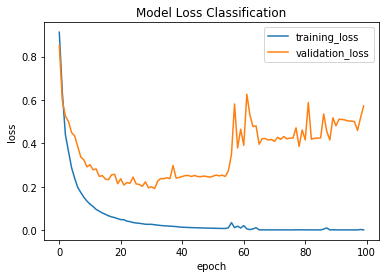

In [21]:
plt.plot(result1.history['loss'])
plt.plot(result1.history['val_loss'])
plt.title('Model Loss Classification')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()

When comparing the four different models using TF-IDF and Word Embedded Vectors it seems the precision and recall accuracy is not as high as the standard model given the parameters provided, additional tweaking will be need to finally find maximum accuracy and effiency. There might be missing model for the network process. Given the dataset it seems more balenced in terms of sample and weight. There are more options but limited to overfitting process.

## 2. Sentiment Analysis 

In [22]:
with open('./a4-data/q2/negative.review', encoding="utf8", errors='ignore') as f:
    negative = [line.strip() for line in f.readlines()]
with open('./a4-data/q2/positive.review', encoding="utf8", errors='ignore') as f:
    positive = [line.strip() for line in f.readlines()]

In [23]:
# Define a function to extract the review text from <review_text>
def review_text_extract(text_list):
    reviews = []
    for i in range(len(text_list)):
        if text_list[i] == '<review_text>':
            k = 1
            while text_list[i+k] != '</review_text>':
                k += 1
            review = ''.join(text_list[i+1:i+k])
            reviews.append(review)
    return reviews

In [24]:
#confirm number of review extracted
positive_reviews = review_text_extract(positive)
print(len(positive_reviews))

negative_reviews = review_text_extract(negative)
print(len(negative_reviews))

1000
1000


In [25]:
def review_to_df(p,n):
    cate_array_positive = np.ones((len(p),)) 
    cate_array_negative = np.zeros((len(n),))     
    df_positive = pd.DataFrame({'reviews': p, 'category':cate_array_positive})
    df_negative = pd.DataFrame({'reviews': n, 'category':cate_array_negative})
    df = pd.concat([df_positive,df_negative])
    return df

df2 = review_to_df(positive_reviews,negative_reviews)
df2

,reviews,category
0,"Bridget Jones, modern day woman, brillant and ...",1.0
1,I am ordering copies for all 23 middle school ...,1.0
2,As a casual piano player and a Broadway fanati...,1.0
3,This is one of the best biographies I have eve...,1.0
4,"I read this book many, many years ago on a ver...",1.0
...,...,...
995,This book provides excellent information about...,0.0
996,I really didn't enjoy this book. I am half It...,0.0
997,This book is a place to start at best. The ma...,0.0
998,I was barely able to finish this book. Armstro...,0.0


In [26]:
def process_review(df):
    X = df.iloc[:,0]
    y = df.iloc[:,1]
    sentences = X.values
    y = y
    sentences_train, sentences_test, y_train,y_test = train_test_split(sentences, y, test_size=0.1, random_state=11)
    X_train, X_val, y_train, y_val = train_test_split(sentences_train, y_train, test_size=0.1, random_state=4)

    tokenizer = Tokenizer(num_words=500)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_validation = tokenizer.texts_to_sequences(X_val)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1                          

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    print('Shape of x_train: ' + str(X_train.shape))
    print('Shape of y_train: ' + str(y_train.shape))
    print('Shape of x_validation: ' + str(X_validation.shape))
    print('Shape of y_validation: ' + str(y_val.shape))
    print('Shape of x_test: ' + str(X_test.shape))
    print('Shape of y_test: ' + str(y_test.shape))
    return X_train, y_train, X_validation, y_val, X_test, y_test, (vocab_size, maxlen)

In [37]:
    inputs = Input(shape=(maxlen,))
    embedding = Embedding(vocab_size, 20)(inputs)
    # layer 1
    conv1 = Conv1D(filters=6, kernel_size=3, activation='relu')(embedding)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=3)(drop1)
    flat1 = Flatten()(pool1)
    # layer 2
    conv2 = Conv1D(filters=12, kernel_size=4, activation='softmax')(embedding)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=3)(drop2)
    flat2 = Flatten()(pool2)
    # merge
    merged = concatenate([flat1,flat2])
    # interpretation
    drop3 = Dropout(0.5)(merged)
    dense1 = Dense(10, activation='relu')(drop3)
    outputs = Dense(2, activation='softmax')(dense1)
    sen_model = Model(inputs=[inputs], outputs=outputs)
    # compile
    sen_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    # summarize
    print(sen_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 20)      416500      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 98, 6)        366         embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 97, 12)       972         embedding_4[0][0]                
____________________________________________________________________________________________

Shape of x_train: (1620, 100)
Shape of y_train: (1620,)
Shape of x_validation: (180, 100)
Shape of y_validation: (180,)
Shape of x_test: (200, 100)
Shape of y_test: (200,)


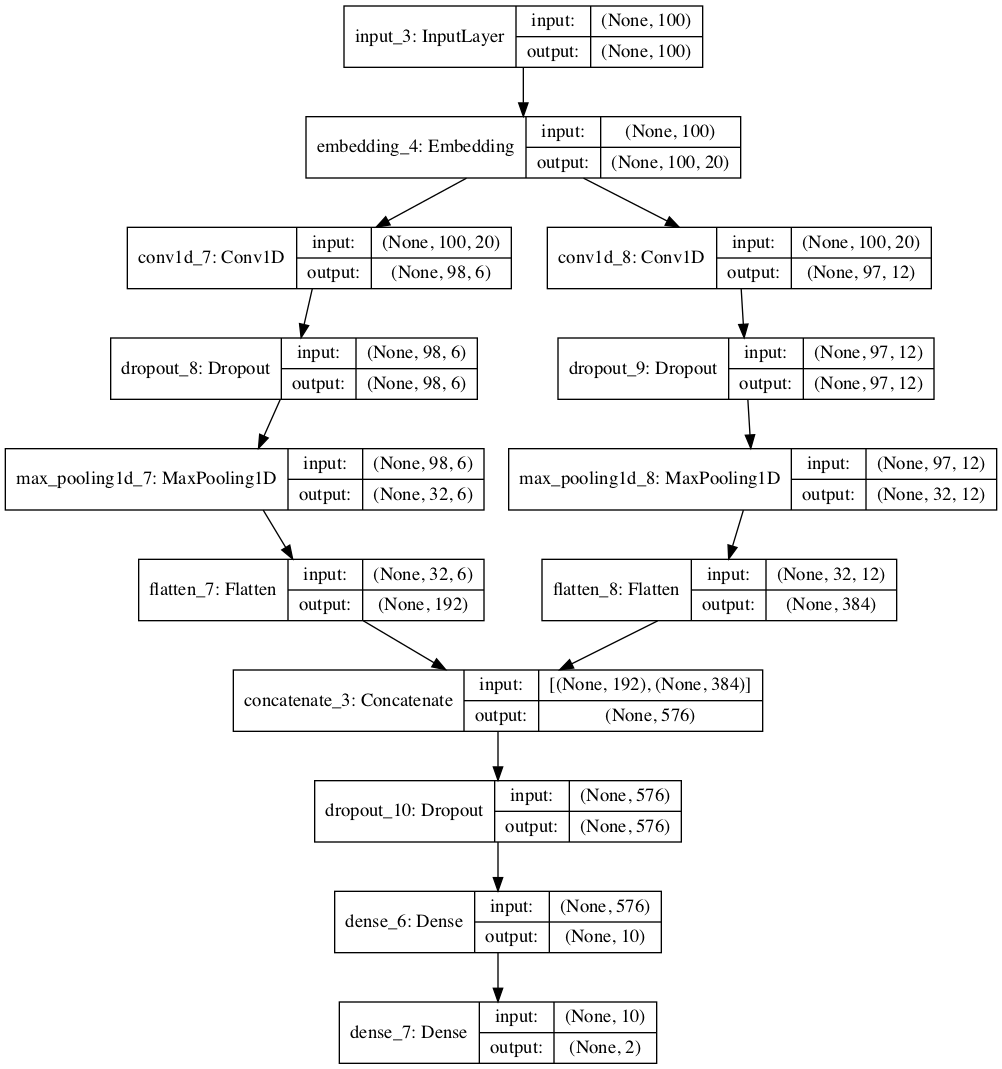

In [38]:
x_train, y_train, x_val, y_val,x_test, y_test, (vocab_size, maxlen) = process_review(df2)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test_c = to_categorical(y_test)

plot_model(sen_model, show_shapes=True, to_file='sentiment_model.png')

In [39]:
result2 = sen_model.fit([x_train], y_train, epochs=100, validation_data=([x_val], y_val), batch_size=8)

Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 3s 2ms/step - loss: 0.6954 - accuracy: 0.4889 - val_loss: 0.6929 - val_accuracy: 0.5167
Epoch 2/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 3/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4981 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 4/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4846 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 5/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4846 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 6/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4883 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 7/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933

Epoch 57/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 58/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 59/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 60/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4833 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 61/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4772 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 62/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 63/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4932 - val_loss: 0.6933 -

In [43]:
loss_and_acc = sen_model.evaluate([x_test], y_test_c)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

200/200 [==============================] - 0s 158us/step
loss = 0.6931491518020629
accuracy = 0.5


In [44]:
y_pred_NN = sen_model.predict([x_test], batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_bool))

200/200 [==============================] - 0s 341us/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       100
         1.0       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



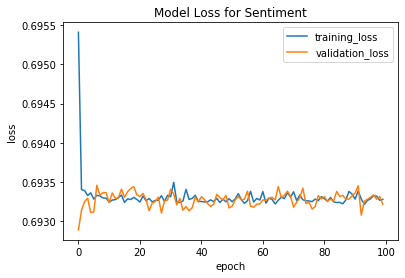

In [45]:
plt.plot(result2.history['loss'])
plt.plot(result2.history['val_loss'])
plt.title('Model Loss for Sentiment')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()

When comparing LSTM vs CNN model for sentiment in the binary perspective CNN seems to overfit quite a bit due to limited dataset, and LSTM have a better precision and recall value